In [1]:
#### basic libraries
import numpy as np
import pandas as pd
import pylab
import math
from datetime import datetime

### Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("seaborn")

### Train/Test Split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

### Feature engineering
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, MinMaxScaler, Normalizer, OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.datasets import make_regression

#Pipeline
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PolynomialFeatures

#Transform
from sklearn.compose import make_column_transformer, ColumnTransformer

### Gridsearch
from sklearn.model_selection import GridSearchCV


import warnings 
warnings.filterwarnings(action='ignore')

# Data

In [2]:
df = pd.read_csv("../data/train.csv", index_col=0, parse_dates=True)
test = pd.read_csv("../data/test.csv", index_col=0, parse_dates=True)
df = df.copy(deep=True)

In [3]:
df = df.rename({'count': 'demand'}, axis=1)

In [4]:
#Extract features like hour, month etc. from the datetime column.
df["year"] = df.index.year
df["month"] = df.index.month
df["week"] = df.index.week
df["day"] = df.index.day
df["hour"] = df.index.hour

C:\Users\power\AppData\Local\Temp\ipykernel_2740\4155312670.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df["week"] = df.index.week


In [5]:
df = df.round({"atemp" : 0, "temp": 0, "windspeed":0})
df.drop(["registered", "casual"], axis = 1, inplace=True)
df.head(1)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,demand,year,month,week,day,hour
datetime,,,,,,,,,,,,,,
2011-01-01,1,0,0,1,10.0,14.0,81,0.0,16,2011,1,52,1,0


# Data Exploration

<AxesSubplot:>

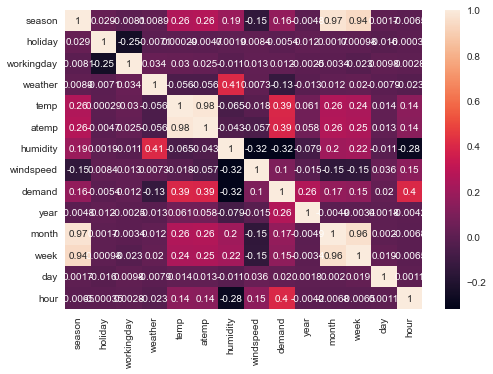

In [6]:
sns.heatmap(df.corr(), annot=True)

array([[<AxesSubplot:title={'center':'season'}>,
        <AxesSubplot:title={'center':'holiday'}>,
        <AxesSubplot:title={'center':'workingday'}>,
        <AxesSubplot:title={'center':'weather'}>],
       [<AxesSubplot:title={'center':'temp'}>,
        <AxesSubplot:title={'center':'atemp'}>,
        <AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>],
       [<AxesSubplot:title={'center':'demand'}>,
        <AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'month'}>,
        <AxesSubplot:title={'center':'week'}>],
       [<AxesSubplot:title={'center':'day'}>,
        <AxesSubplot:title={'center':'hour'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

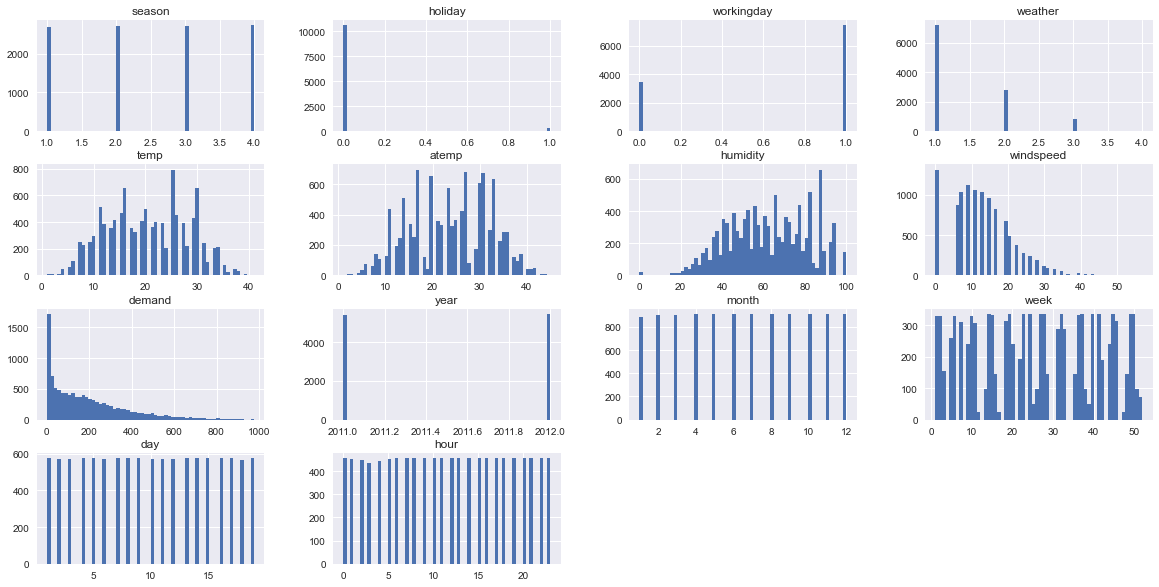

In [7]:
df.hist(bins=60, figsize=(20,10))

<AxesSubplot:xlabel='datetime'>

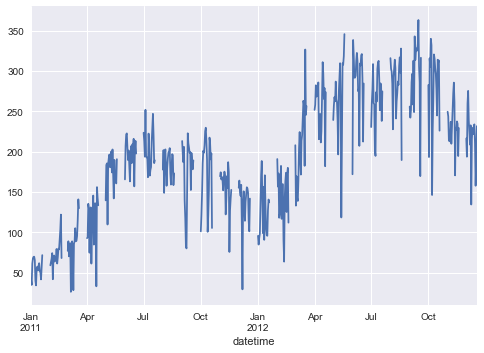

In [8]:
df.resample('D')['demand'].mean().plot()
#data just goes until 19th of each month

<AxesSubplot:xlabel='datetime'>

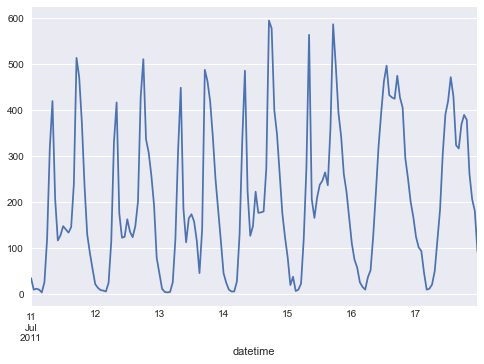

In [45]:
week = df.loc["2011-07-11":"2011-07-17"]
week.demand.plot()

(0.0, 143456.65)

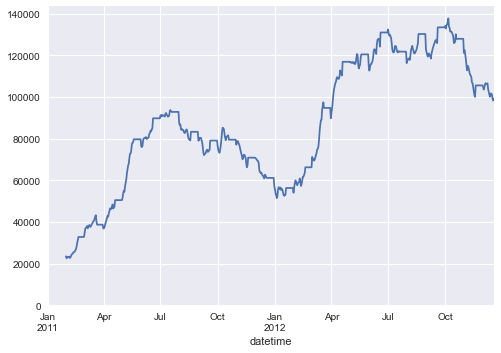

In [10]:
ax = df.demand.resample("D").sum().rolling(30).sum().plot()
ax.set_ylim(0, None)

<AxesSubplot:xlabel='time'>

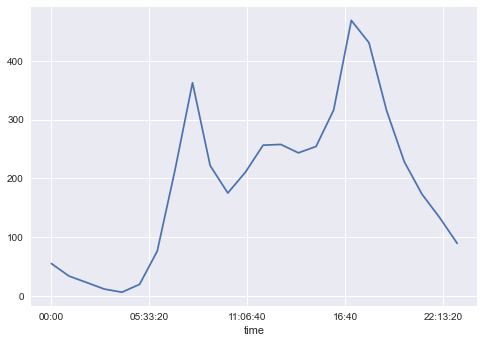

In [47]:
aveday = df.groupby(df.index.time).mean()
aveday.demand.plot()

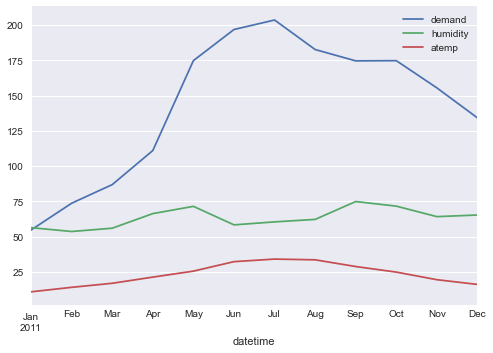

In [13]:
year2011 = df.loc["2011"]
year2011.demand.resample("M").mean().plot()
year2011.humidity.resample("M").mean().plot()
year2011.atemp.resample("M").mean().plot()
plt.legend()

# Split Data

In [15]:
# Define our independent variable/ initial features
X = df.drop('demand', axis=1) 
# Define output target variable
y = df['demand']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state= 42)

# Feature Engineering

In [18]:
# drop season, atemp
# extract feature importance: day, weather, holiday lowest scores -> drop
# select significant features: holiday, weekday and day had high p-values

In [19]:
X_train.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'year', 'month', 'week', 'day', 'hour'],
      dtype='object')

In [20]:
# Defining transformers and features
num_tr = MinMaxScaler()
num_fe = ["temp", "atemp", "humidity", "windspeed"]

#cyc_fe = ["hour_cos", "hour_sin", "month_cos", "month_sin"]

time_tr = KBinsDiscretizer(n_bins=12, encode='onehot')
time_fe = ["hour", "month"]

In [21]:
#Creating column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_tr, num_fe),
        ("time", time_tr, time_fe)
    ], 
    remainder="passthrough")

In [22]:
poly = PolynomialFeatures(degree=2, include_bias=False)

# create pipelines
pipeline_linear = make_pipeline(preprocessor, LinearRegression(normalize=True))
pipeline_poly = make_pipeline(preprocessor, poly, LinearRegression(normalize=True))
#pipeline_rf = make_pipeline(preprocessor, RandomForestRegressor(normalize=True))


In [23]:
pipeline_poly

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['temp', 'atemp', 'humidity',
                                                   'windspeed']),
                                                 ('time',
                                                  KBinsDiscretizer(n_bins=12),
                                                  ['hour', 'month'])])),
                ('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('linearregression', LinearRegression(normalize=True))])

**Results from Gridsearch:**

- Best parameters:
 'copy_X': True,
 'fit_intercept': True,
 'n_jobs': 2,
 'normalize': True,
 'positive': False
 
- Default:
fit_intercept=True, normalize='deprecated', copy_X=True, n_jobs=None, positive=False

# Modeling

In [24]:
#Turn demand(bike count) into log-scale
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [25]:
# Fit the pipeline to X_train
pipeline_linear.fit(X_train,y_train_log)
pipeline_poly.fit(X_train,y_train_log)

c:\Users\power\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\power\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
c:\Users\power\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whos

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['temp', 'atemp', 'humidity',
                                                   'windspeed']),
                                                 ('time',
                                                  KBinsDiscretizer(n_bins=12),
                                                  ['hour', 'month'])])),
                ('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('linearregression', LinearRegression(normalize=True))])

In [26]:
# need for transformation of test data?

In [27]:
#R2 for model
pipeline_linear.score(X_train, y_train_log), pipeline_poly.score(X_train, y_train_log)

(0.7943512935445242, 0.9022473830090786)

In [28]:
#R2 for model
pipeline_linear.score(X_test, y_test_log), pipeline_poly.score(X_test, y_test_log)

(0.7892176006191044, 0.8929493210284551)

In [29]:
# Predict y_pred
y_predlog_test = pipeline_linear.predict(X_test)
y_pred = np.exp(y_predlog_test)-1

# Predict y_pred_poly
y_predlog_poly = pipeline_poly.predict(X_test)
y_pred_poly = np.exp(y_predlog_poly)-1

In [30]:
# check MSLE score for y_test
np.sqrt(mean_squared_log_error(y_test, y_pred)), np.sqrt(mean_squared_log_error(y_test, y_pred_poly))

(0.6493650113300474, 0.4627713090661592)

# Randomforest Regression

In [31]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.datasets import make_regression
# X, y = make_regression(n_features=4, n_informative=2, random_state=0, shuffle=False)
# regr = RandomForestRegressor(max_depth=2, random_state=0)
# regr.fit(X, y)
# RandomForestRegressor()
# print(regr.predict([[0, 0, 0, 0]]))

X_train, y_train = make_regression(n_features=4, n_informative=2, random_state=0, shuffle=False)
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, y_train)
RandomForestRegressor()
print(regr.predict([[0, 0, 0, 0]]))


[-8.32987858]


In [33]:
#make pipeline
pipeline_poly_forest = make_pipeline(preprocessor, poly, RandomForestRegressor(max_depth= 7, n_estimators= 50))

#Turn demand(bike count) into log-scale
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Fit the pipeline to X_train
pipeline_poly_forest.fit(X_train,y_train_log)

#R2 for model
pipeline_poly_forest.score(X_train, y_train_log), pipeline_poly_forest.score(X_test, y_test_log)

# Predict y_pred_poly
y_predlog_poly_forest = pipeline_poly_forest.predict(X_test)
y_pred_poly_forest = np.exp(y_predlog_poly_forest)-1

# check MSLE score for y_test
np.sqrt(mean_squared_log_error(y_test, y_pred_poly_forest))

C:\Users\power\AppData\Local\Temp\ipykernel_2740\4146373773.py:6: RuntimeWarning: invalid value encountered in log1p
  y_train_log = np.log1p(y_train)


ValueError: Specifying the columns using strings is only supported for pandas DataFrames

# Crossvalidation

In [34]:
X_train_trans = preprocessor.transform(X_train)
X_test_trans = preprocessor.transform(X_test)

cv_list = cross_val_score(LinearRegression(), X_train_trans, y_train_log,  cv = 5)

ValueError: Specifying the columns using strings is only supported for pandas DataFrames

In [ ]:
cv_list

array([0.80388748, 0.80055937, 0.7745947 , 0.78751732, 0.79392925])

# Gridsearch

In [ ]:
m = LinearRegression()
m_f = RandomForestRegressor()

In [ ]:
# estimator - a model
# param_grid - a dictionary with parameters to try
grid_m = GridSearchCV(m, {
    'fit_intercept': [True, False],
    'normalize': [True, False], 
    'copy_X': [True], 
    'positive': [False],
    'n_jobs':[2]
})

In [ ]:
grid_m_f = GridSearchCV(m_f, {
    'n_estimators' : [50, 100, 120, 140],
    'max_depth': [3, 4, 5, 7],
    
})

In [ ]:
grid_m.fit(X_train, y_train)
print(grid_m.score(X_test, y_test))

grid_m_f.fit(X_train, y_train)
print(grid_m_f.score(X_test, y_test))

0.3871832731290732
0.8231001328662383


In [ ]:
print(grid_m.best_params_)

print(grid_m_f.best_params_)
# {'max_depth': 7, 'n_estimators': 50}, 0.8023745977661002

{'copy_X': True, 'fit_intercept': True, 'n_jobs': 2, 'normalize': True, 'positive': False}
{'max_depth': 7, 'n_estimators': 50}


In [ ]:
m = grid_m.best_estimator_

m_f = grid_m_f.best_estimator_

In [ ]:
ypred = m_f.predict(X_test)
y_pred

array([216.62022683,  56.00573378, 280.62149832, ...,   9.90899199,
       267.95483262,  52.89623085])

# Visualize 

<AxesSubplot:xlabel='datetime'>

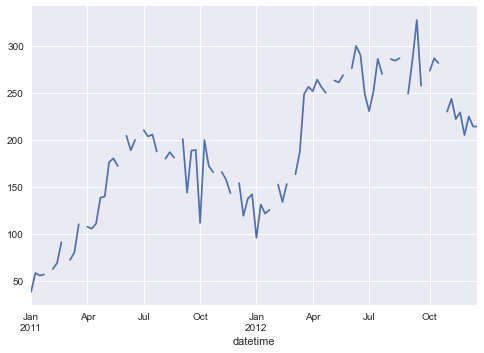

In [ ]:
#from train.csv 
week = df.demand.resample("W").mean()
week.plot()

In [ ]:
# Predict y_pred
y_pred_test = pipeline_linear.predict(X_test)
ypred = np.exp(y_pred_test)-1

y_pred_train = pipeline_linear.predict(X_train)
ypred_tr = np.exp(y_pred_train)-1

# predict with random forest
y_pred_test_rf = pipeline_poly_forest.predict(X_test)
ypred_rf = np.exp(y_pred_test)-1

y_pred_train_rf = pipeline_poly_forest.predict(X_train)
ypred_tr_rf = np.exp(y_pred_train)-1

In [ ]:
predtest = pd.DataFrame({"datetime" : X_test.index.values, "count" : y_pred_test})
predtrain = pd.DataFrame({"datetime" : X_train.index.values, "count" : y_pred_train})


predtest_rf = pd.DataFrame({"datetime" : X_test.index.values, "count" : y_pred_test_rf})
predtrain_rf = pd.DataFrame({"datetime" : X_train.index.values, "count" : y_pred_train_rf})

In [ ]:
predtest.set_index("datetime", inplace=True)
predtrain.set_index("datetime", inplace=True)

predtest_rf.set_index("datetime", inplace=True)
predtrain_rf.set_index("datetime", inplace=True)

<AxesSubplot:xlabel='datetime'>

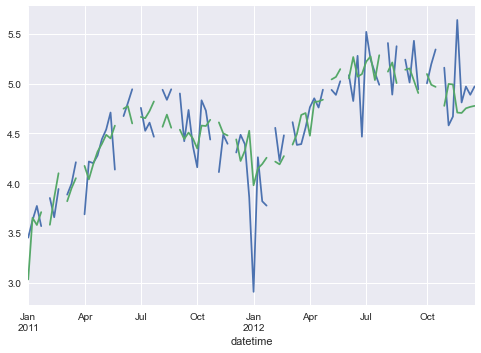

In [ ]:
predtest["count"].resample("W").mean().plot()
predtrain["count"].resample("W").mean().plot()

<AxesSubplot:xlabel='datetime'>

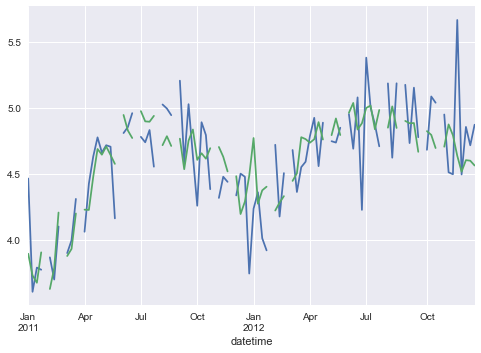

In [ ]:
predtest_rf["count"].resample("W").mean().plot()
predtrain_rf["count"].resample("W").mean().plot()

# Real Test Data

In [ ]:
df_test = pd.read_csv("../data/test.csv", index_col=0, parse_dates=True)
df_test

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
datetime,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014
...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014
2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014
2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014


In [ ]:
#Extract features like hour, month etc. from the datetime column.
df_test["year"] = df_test.index.year
df_test["month"] = df_test.index.month
df_test["day"] = df_test.index.day
df_test["hour"] = df_test.index.hour
df_test["week"] = df_test.index.week

In [ ]:
predictions = pipeline_linear.predict(df_test)
predictions
# some predictions are negative --> turn them to zero

array([ 2.82000732e+00,  1.88970947e+00,  1.88970947e+00, ...,
       -2.75799541e+11, -2.75799541e+11, -2.75799541e+11])

In [ ]:
predictions = np.where(predictions < 0, 0, predictions)
predictions

array([2.82000732, 1.88970947, 1.88970947, ..., 0.        , 0.        ,
       0.        ])

In [ ]:
Submission_df = pd.DataFrame({"datetime" : df_test.index.values, "count" : predictions.round()})
Submission_df

In [ ]:
Submission_df.to_csv("./Submissions.csv", index=False)